# Locality Sensitive Hashing
A Python implementation for the [Introduction to Big Data Algorithms](https://sites.google.com/view/ibda-summer23/home) course at the [University of Salzburg](https://www.plus.ac.at/) in the summer semester 2023. The goal of this notebook is to compare different approaches of finding near-duplicate documents in a list of job announcements.

In [235]:
import pandas as pd
import matplotlib.pyplot as plt

from time import perf_counter
from tqdm import tqdm

from src.shingling import get_shingles
from src.metrics import jaccard_similarity, signature_similarity
from src.min_hash import MinHash
from src.LSH import LSH

We say that two documents are near duplicates if their Jaccard similarity is $\geq 0.8$.

In [236]:
s: float = 0.8 # similarity threshold
k: int = 10 # length of the shingles

In terms of signature length $h$ and thus also values for $r$ and $b$, we first need to observe how long the shingled documents are. Each job announcement is quite long and can easily go beyond 1000 shingles for shingle length 10. We want to to test different setups. Using the min-hash property $\mathbb P[s_1[i] = s_2[i]] = \text{sim}(D_1,D_2)$, I argue for the following values as they represent different probabilities for false positives and false negatives.

- $r=5$ and $b=20$ $\Rightarrow h=100$. 
    - Then if the similarity of two documents is $0.8$, the probability that they are NOT similar in all bands is $(1-(0.8)^5)^{20} = 0.00035$.
    - And if the similarity of two documents is $0.3$, the probability that they identical in at least one band is $1-(1-(0.3)^5)^{20} = 0.0474$.
- $r=6$ and $b=10$ $\Rightarrow h=60$. 
    - Then if the similarity of two documents is $0.8$, the probability that they are NOT similar in all bands is $(1-(0.8)^6)^{10} = 0.04783$.
    - And if the similarity of two documents is $0.3$, the probability that they identical in at least one band is $1-(1-(0.3)^6)^{10} = 0.00726$.
- $r=7$ and $b=25$ $\Rightarrow h=175$. 
    - Then if the similarity of two documents is $0.8$, the probability that they are NOT similar in all bands is $(1-(0.8)^7)^{25} = 0.00278$.
    - And if the similarity of two documents is $0.3$, the probability that they identical in at least one band is $1-(1-(0.3)^7)^{25} = 0.00545$.

In [237]:
setups: dict = {
    0: { 'r': 5, 'b': 20, 'h': 100 },
    1: { 'r': 6, 'b': 10, 'h': 60 },
    2: { 'r': 7, 'b': 25, 'h': 175 },
}

## 0. Load the Data
First, we need to load the data. To make comparisons, we use the data set `job-ads.txt` located in `data`. I also prepared a larget data set `job-ads-large.txt` where I copied each entry four times to make more meaningful performance comparisons.

In [238]:
jobs: pd.DataFrame = pd.read_csv('./data/job-ads.txt', header=None)
jobs.rename(columns = {0:'text'}, inplace = True)

# normally, makes sense to put to lowercase when processing it
jobs['text'] = jobs['text'].apply(lambda x: x.lower())

# print the head
jobs.head()

,text
0,movia spa opera da oltre un decennio nel merca...
1,cerchiamo un grafico web designer da inserire ...
2,"blog di anime, manga e videogames cerca artico..."
3,"dps soluzioni informatiche, società specializz..."
4,società operante nell'ambito della comunicazio...


We do the equivalent for the large data frame.

In [239]:
jobs_large: pd.DataFrame = pd.read_csv('./data/job-ads-large.txt', header=None)
jobs_large.rename(columns = {0:'text'}, inplace = True)
jobs_large['text'] = jobs_large['text'].apply(lambda x: x.lower())

## 1. Naive Comparison of Shingles
The first approach to search for near-duplicates will be a naive comparison of shingles. That is, we shingle each document and compare them directly using the Jaccard similarity. We find near duplicates by finding the near duplicate for each job announcement, i.e. create pairs.

In [240]:
# let's compute the shingles first
naive_shingles: list[set[str]] = jobs['text'].apply(lambda x: get_shingles(document=x, k=k, compressed=False))

In [241]:
# prepare a holding data structure for times and statistics
times: dict = {}
fp: dict = {}
fn: dict = {}

Then we can go ahead and try to get pairs of (near) duplicates.

In [242]:
# start time
t1: float = perf_counter()

# set of duplicates - the set makes sure that duplicates like (1,2) and (2,1) don't occur
duplicates_naive: set[frozenset[int]] = set()

# go through each row
for idx, shingle in tqdm(enumerate(naive_shingles), total=len(naive_shingles)):
    
    # compare the text with each other text
    for candidate_idx, candidate_shingle in enumerate(naive_shingles):
        sim: float = jaccard_similarity(shingle, candidate_shingle)
        if sim >= s and idx != candidate_idx:
            duplicates_naive.add(frozenset((idx, candidate_idx)))
            
# stop time
t2: float = perf_counter()
elapsed_time_naive: float = t2 - t1
times[f'naive'] = t2 - t1
print(f'Elapsed time: {times[f"naive"]} seconds')

# compute false negatives and false positives
fp[f'naive'] = 0 # as this is the "true" baseline
fn[f'naive'] = 0 # as this is the "true" baseline
print(f'False positives (fp): {fp[f"naive"]}')
print(f'False negatives (fn): {fn[f"naive"]}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1530/1530 [02:11<00:00, 11.62it/s]

Elapsed time: 131.73439758499444 seconds
False positives (fp): 0
False negatives (fn): 0


There can't be any false positives or false negatives since we compute the true (actual) similarity.

## 2. Minhash Comparison
We can also try to find documents by comparing their minhash signature in a pairwise manner. In other words, we only try to estimate the document's similarities.

### 2.1. Minhashing without Filtering
Since the pairwise comparisons of minhash signatures are of probabilistic nature, we might get some false positives, i.e. detected "near duplicates" that are no duplicates in reality. In the first step, we ignore those false positives.

In [243]:
compressed_shingles: list[set[int]] = jobs['text'].apply(lambda x: get_shingles(document=x, k=k))

# compute signatures for different choices of r and b
signatures: dict[list[int]] = {}

for key in setups.keys():
    print(f'Preparing minhash representation for {setups[key]}')
    
    # setup a minhash instance
    minhash: MinHash = MinHash(K=setups[key]['h'])
    
    # and compute the signature
    signatures[key] = []
    for shingle_set in compressed_shingles:
        signatures[key].append(minhash.minhash(shingle_set))

Preparing minhash representation for {'r': 5, 'b': 20, 'h': 100}
Preparing minhash representation for {'r': 6, 'b': 10, 'h': 60}
Preparing minhash representation for {'r': 7, 'b': 25, 'h': 175}


After pre-computing the min-hash signatures, we can then make pairwise comparisons of the document signatures.

In [244]:
duplicates = {}
for key in setups.keys():
    print(f'Running minhash similarity search (without filtering) for {setups[key]}')
    
    # start time
    t1: float = perf_counter()

    # set of duplicates - the set makes sure that duplicates like (1,2) and (2,1) don't occur
    duplicates[key]: set[frozenset[int]] = set()

    # go through each row
    for idx, signature in tqdm(enumerate(signatures[key]), total=len(signatures[key])):

        # compare the text with each other text
        for candidate_idx, candidate_signature in enumerate(signatures[key]):
            sim: float = signature_similarity(signature, candidate_signature)
            if sim >= s and idx != candidate_idx:
                duplicates[key].add(frozenset((idx, candidate_idx)))

    # stop time
    t2: float = perf_counter()
    times[f'minhash_{key}'] = t2 - t1
    print(f'Elapsed time: {times[f"minhash_{key}"]} seconds')
    
    # compute false negatives and false positives
    fp[f'minhash_{key}'] = len(duplicates[key].difference(duplicates_naive))
    fn[f'minhash_{key}'] = len(duplicates_naive.difference(duplicates[key]))
    print(f'False positives (fp): {fp[f"minhash_{key}"]}')
    print(f'False negatives (fn): {fn[f"minhash_{key}"]}')

Running minhash similarity search (without filtering) for {'r': 5, 'b': 20, 'h': 100}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:12<00:00, 122.40it/s]


Elapsed time: 12.504184445991996 seconds
False positives (fp): 36
False negatives (fn): 10
Running minhash similarity search (without filtering) for {'r': 6, 'b': 10, 'h': 60}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:07<00:00, 203.44it/s]


Elapsed time: 7.524384333999478 seconds
False positives (fp): 16
False negatives (fn): 16
Running minhash similarity search (without filtering) for {'r': 7, 'b': 25, 'h': 175}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:21<00:00, 72.33it/s]

Elapsed time: 21.155605669002398 seconds
False positives (fp): 9
False negatives (fn): 5


### 2.2 Minhashing with Filtering
In the second step, we remove false positives by checking the actual Jaccard similarity of the assumed near duplicate pairs.

In [245]:
duplicates = {}
for key in setups.keys():
    print(f'Running minhash similarity search (with filtering) for {setups[key]}')
    
    # start time
    t1: float = perf_counter()

    # set of duplicates - the set makes sure that duplicates like (1,2) and (2,1) don't occur
    duplicates[key]: set[frozenset[int]] = set()

    # go through each row
    for idx, signature in tqdm(enumerate(signatures[key]), total=len(signatures[key])):

        # compare the text with each other text using its minhash signature
        for candidate_idx, candidate_signature in enumerate(signatures[key]):
            sim: float = signature_similarity(signature, candidate_signature)
            if sim >= s and idx != candidate_idx:
                
                # additionally, check the actual Jaccard similarity of the candidate pair 
                actual_sim: float = jaccard_similarity(compressed_shingles[candidate_idx], compressed_shingles[idx])
                if actual_sim >= s:
                    duplicates[key].add(frozenset((idx, candidate_idx)))

    # stop time
    t2: float = perf_counter()
    times[f'minhash_filtered_{key}'] = t2 - t1
    print(f'Elapsed time: {times[f"minhash_{key}"]} seconds')
    
    # compute false negatives and false positives
    fp[f'minhash_filtered_{key}'] = len(duplicates[key].difference(duplicates_naive))
    fn[f'minhash_filtered_{key}'] = len(duplicates_naive.difference(duplicates[key]))
    print(f'False positives (fp): {fp[f"minhash_filtered_{key}"]}')
    print(f'False negatives (fn): {fn[f"minhash_filtered_{key}"]}')

Running minhash similarity search (with filtering) for {'r': 5, 'b': 20, 'h': 100}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:15<00:00, 97.47it/s]


Elapsed time: 12.504184445991996 seconds
False positives (fp): 0
False negatives (fn): 10
Running minhash similarity search (with filtering) for {'r': 6, 'b': 10, 'h': 60}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:10<00:00, 141.90it/s]


Elapsed time: 7.524384333999478 seconds
False positives (fp): 0
False negatives (fn): 16
Running minhash similarity search (with filtering) for {'r': 7, 'b': 25, 'h': 175}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:24<00:00, 62.73it/s]

Elapsed time: 21.155605669002398 seconds
False positives (fp): 0
False negatives (fn): 5


## 3. LSH
Now to the interesting part: We use locality-sensitive hashing for our near-duplicate search by inserting all documents into the LSH data structure we implemented and query the data structure for each document and collect all candidate pairs.

### 3.1. LSH with Minhash Filtering
In the first part, we remove false positives by esitmating the Jaccard similarity of pairs using their minhash signature.

In [246]:
duplicates = {}
for key in setups.keys():
    print(f'Running LSH-based similarity search (with minhash filtering) for {setups[key]}')
    
    # start time
    t1: float = perf_counter()

    # set of duplicates - the set makes sure that duplicates like (1,2) and (2,1) don't occur
    duplicates[key]: set[frozenset[int]] = set()

    # insert all documents into the LSH data structure
    lsh: LSH = LSH(h=setups[key]['h'], r=setups[key]['r'], b=setups[key]['b'])
    for idx, signature in enumerate(signatures[key]):
        lsh.insert(idx, signature)
        
    # query the lsh data structure and collect all candidate pairs 
    for idx, signature in tqdm(enumerate(signatures[key]), total=len(signatures[key])):
        candidates: set[int] = lsh.query(signature)
        candidates.remove(idx) # remove the id of the document from the candidate set
        
        # check all candidates and remove false positives by comparing their minhash sigantures
        for candidate_idx in candidates:
            sim: float = signature_similarity(signature, signatures[key][candidate_idx])
            if sim >= s and idx != candidate_idx:
                duplicates[key].add(frozenset((idx, candidate_idx)))

    # stop time
    t2: float = perf_counter()
    times[f'lsh_minhash_filter_{key}'] = t2 - t1
    print(f'Elapsed time: {times[f"lsh_minhash_filter_{key}"]} seconds')
    
    # compute false negatives and false positives
    fp[f'lsh_minhash_filter_{key}'] = len(duplicates[key].difference(duplicates_naive))
    fn[f'lsh_minhash_filter_{key}'] = len(duplicates_naive.difference(duplicates[key]))
    print(f'False positives (fp): {fp[f"lsh_minhash_filter_{key}"]}')
    print(f'False negatives (fn): {fn[f"lsh_minhash_filter_{key}"]}')

Running LSH-based similarity search (with minhash filtering) for {'r': 5, 'b': 20, 'h': 100}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:00<00:00, 1681.02it/s]


Elapsed time: 0.9750560360116651 seconds
False positives (fp): 36
False negatives (fn): 10
Running LSH-based similarity search (with minhash filtering) for {'r': 6, 'b': 10, 'h': 60}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:00<00:00, 6192.12it/s]


Elapsed time: 0.2812778369989246 seconds
False positives (fp): 16
False negatives (fn): 16
Running LSH-based similarity search (with minhash filtering) for {'r': 7, 'b': 25, 'h': 175}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:00<00:00, 2399.96it/s]

Elapsed time: 0.7093616289930651 seconds
False positives (fp): 9
False negatives (fn): 5


### 3.2. LSH with Jaccard Filtering
Secondly, let's try to remove false positives by checking the actual Jaccard similarity of candidate pairs instead of merely estimating it.

In [247]:
duplicates = {}
for key in setups.keys():
    print(f'Running LSH-based similarity search (with Jaccard filtering) for {setups[key]}')
    
    # start time
    t1: float = perf_counter()

    # set of duplicates - the set makes sure that duplicates like (1,2) and (2,1) don't occur
    duplicates[key]: set[frozenset[int]] = set()

    # insert all documents into the LSH data structure
    lsh: LSH = LSH(h=setups[key]['h'], r=setups[key]['r'], b=setups[key]['b'])
    for idx, signature in enumerate(signatures[key]):
        lsh.insert(idx, signature)
        
    # query the lsh data structure and collect all candidate pairs 
    for idx, signature in tqdm(enumerate(signatures[key]), total=len(signatures[key])):
        candidates: set[int] = lsh.query(signature)
        candidates.remove(idx) # remove the id of the document from the candidate set
        
        # check all candidates and remove false positives by comparing their minhash sigantures
        for candidate_idx in candidates:
            sim: float = jaccard_similarity(compressed_shingles[candidate_idx], compressed_shingles[idx])
            if sim >= s and idx != candidate_idx:
                duplicates[key].add(frozenset((idx, candidate_idx)))

    # stop time
    t2: float = perf_counter()
    times[f'lsh_jaccard_filter_{key}'] = t2 - t1
    print(f'Elapsed time: {times[f"lsh_jaccard_filter_{key}"]} seconds')
    
    # compute false negatives and false positives
    fp[f'lsh_jaccard_filter_{key}'] = len(duplicates[key].difference(duplicates_naive))
    fn[f'lsh_jaccard_filter_{key}'] = len(duplicates_naive.difference(duplicates[key]))
    print(f'False positives (fp): {fp[f"lsh_jaccard_filter_{key}"]}')
    print(f'False negatives (fn): {fn[f"lsh_jaccard_filter_{key}"]}')

Running LSH-based similarity search (with Jaccard filtering) for {'r': 5, 'b': 20, 'h': 100}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:03<00:00, 466.12it/s]


Elapsed time: 3.3439111019979464 seconds
False positives (fp): 0
False negatives (fn): 0
Running LSH-based similarity search (with Jaccard filtering) for {'r': 6, 'b': 10, 'h': 60}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:03<00:00, 490.99it/s]


Elapsed time: 3.148567483003717 seconds
False positives (fp): 0
False negatives (fn): 1
Running LSH-based similarity search (with Jaccard filtering) for {'r': 7, 'b': 25, 'h': 175}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:03<00:00, 477.66it/s]

Elapsed time: 3.2738516999961575 seconds
False positives (fp): 0
False negatives (fn): 0


What's immediately visible is the quality jump from Minhash Filtering to Jaccard Filtering – both in terms of false positives and false negatives. I suspect that this comes from the fact that the similarity is not estimated anymore. That is, fewer false negatives occur as a pair that exceeds the threshold is never estimated lower and a pair that does not exceed the threshold is never estimated higher.

## 4. Results
To compare the different approaches, let's visualize the runtime, the false positives and false negatives of each. For easier visualization, I convert the benchmark results to dataframes.

In [259]:
# label for each setup
labels: dict = {
    'naive': 'Naive',
    'minhash_0': r'Minhashing [r=5, b=20, h=100]',
    'minhash_1': 'Minhashing [r=6, b=10, h=60]',
    'minhash_2': 'Minhashing [r=7, b=25, h=175]',
    'minhash_filtered_0': 'Minhashing (Filtering) [r=5, b=20, h=100]',
    'minhash_filtered_1': 'Minhashing (Filtering) [r=6, b=10, h=60]',
    'minhash_filtered_2': 'Minhashing (Filtering) [r=7, b=25, h=175]',
    'lsh_minhash_filter_0': 'LSH [r=5, b=20, h=100]',
    'lsh_minhash_filter_1': 'LSH [r=6, b=10, h=60]',
    'lsh_minhash_filter_2': 'LSH [r=7, b=25, h=175]',
    'lsh_jaccard_filter_0': 'LSH (Filtering) [r=5, b=20, h=100]',
    'lsh_jaccard_filter_1': 'LSH (Filtering) [r=6, b=10, h=60]',
    'lsh_jaccard_filter_2': 'LSH (Filtering) [r=7, b=25, h=175]',
}

# create dataframes from the result dictionaries
times_df: pd.DataFrame = pd.DataFrame.from_dict(times, orient='index')
fp_df: pd.DataFrame = pd.DataFrame.from_dict(fp, orient='index')
fn_df: pd.DataFrame = pd.DataFrame.from_dict(fn, orient='index')

# add labels to columns
times_df['label'] = times_df.apply(lambda row: labels[row.name], axis=1)
fp_df['label'] = fp_df.apply(lambda row: labels[row.name], axis=1)
fn_df['label'] = fn_df.apply(lambda row: labels[row.name], axis=1)

### 4.1. Runtimes
Clearly, locality sensitive hashing brings a huge performance boost. Especially when combining it with minhash filtering but also with Jaccard filtering. Using minhash signatures to estimate the similarity also makes the computation a lot faster.

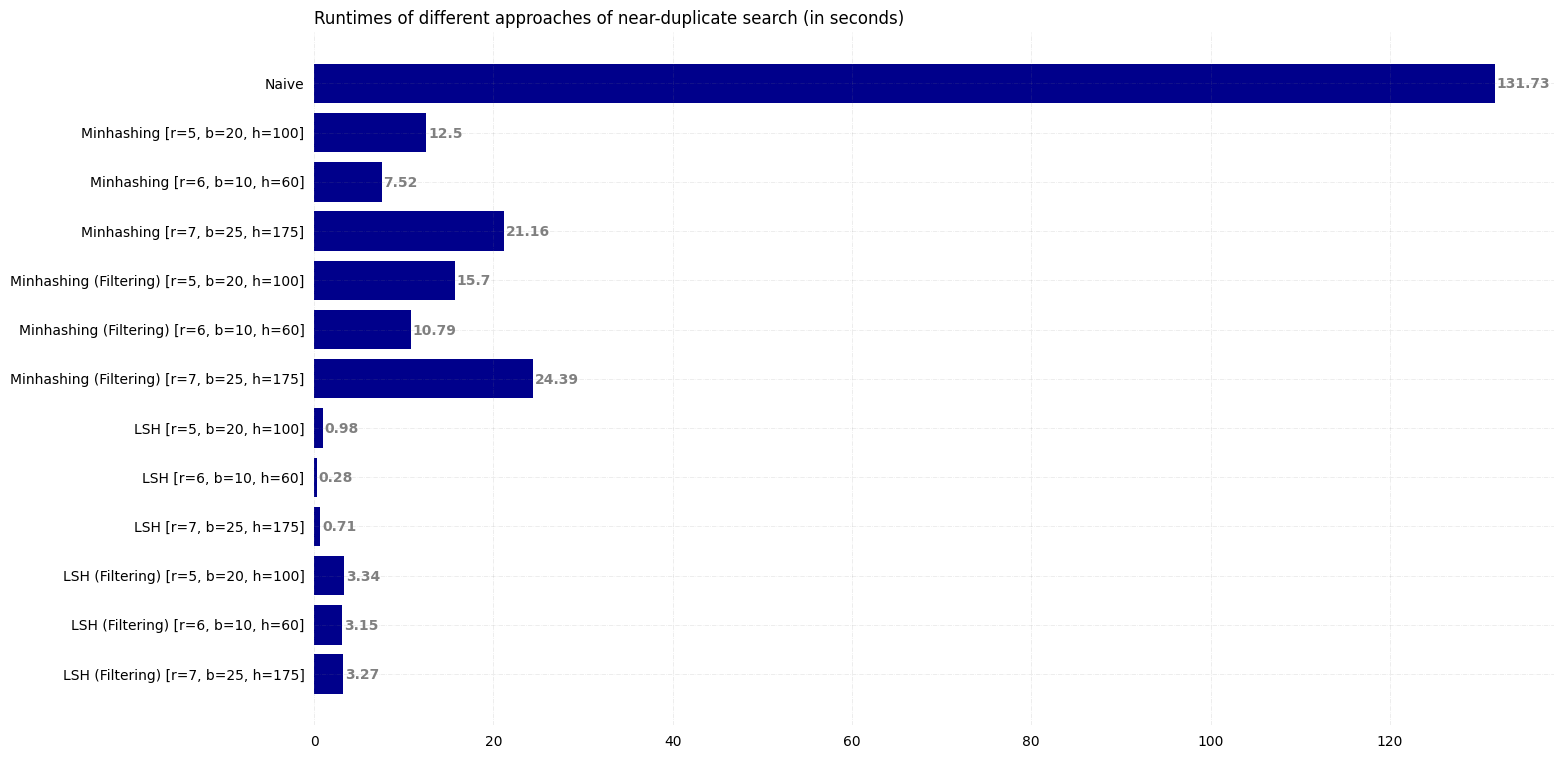

In [275]:
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(times_df['label'].to_list(), times_df[0].to_list(), color='darkblue')

# remove axis lines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
# remove x, y ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# add x, y gridlines
ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# show top values
ax.invert_yaxis()

# add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
    
# add a title
ax.set_title('Runtimes of different approaches of near-duplicate search (in seconds)', loc ='left')
 
plt.show()

### 4.2. False Positives
While the naive and filtered approaches brings almost no false positives, minhash similarity estimates tend to result in a few false positives depending on the parameters. 

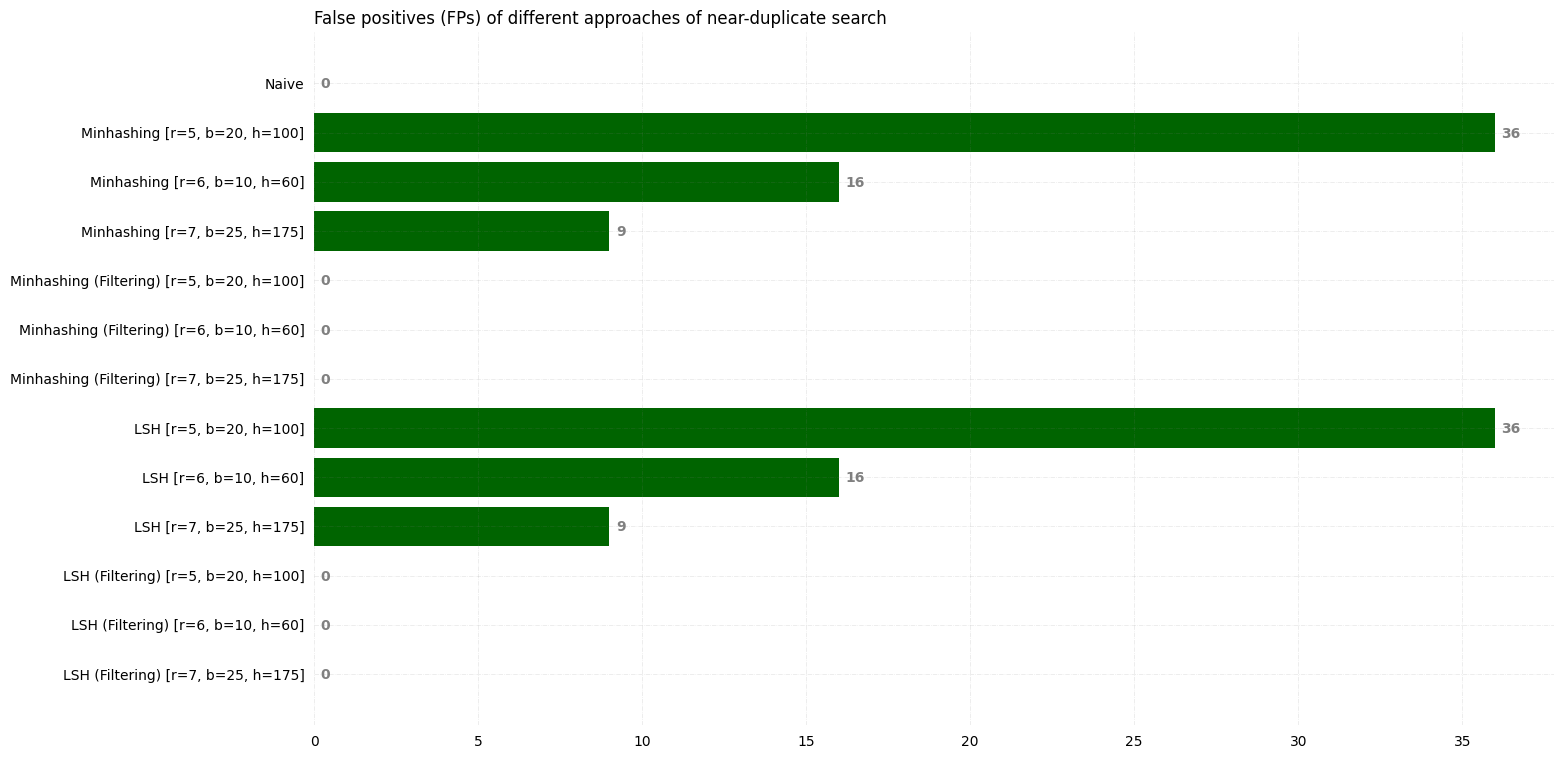

In [276]:
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(fp_df['label'].to_list(), fp_df[0].to_list(), color='darkgreen')

# remove axis lines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
# remove x, y ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# add x, y gridlines
ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# show top values
ax.invert_yaxis()

# add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
    
# add a title
ax.set_title('False positives (FPs) of different approaches of near-duplicate search', loc ='left')
 
plt.show()

### 4.2. False Negatives
Relying only on minhash estimates for similarity does yield a few false negatives every time. Interestingly, LSH with Jaccard filtering is (almost) as good as a full pairwise comparisons of the full (shingled) text – only that it is much faster.

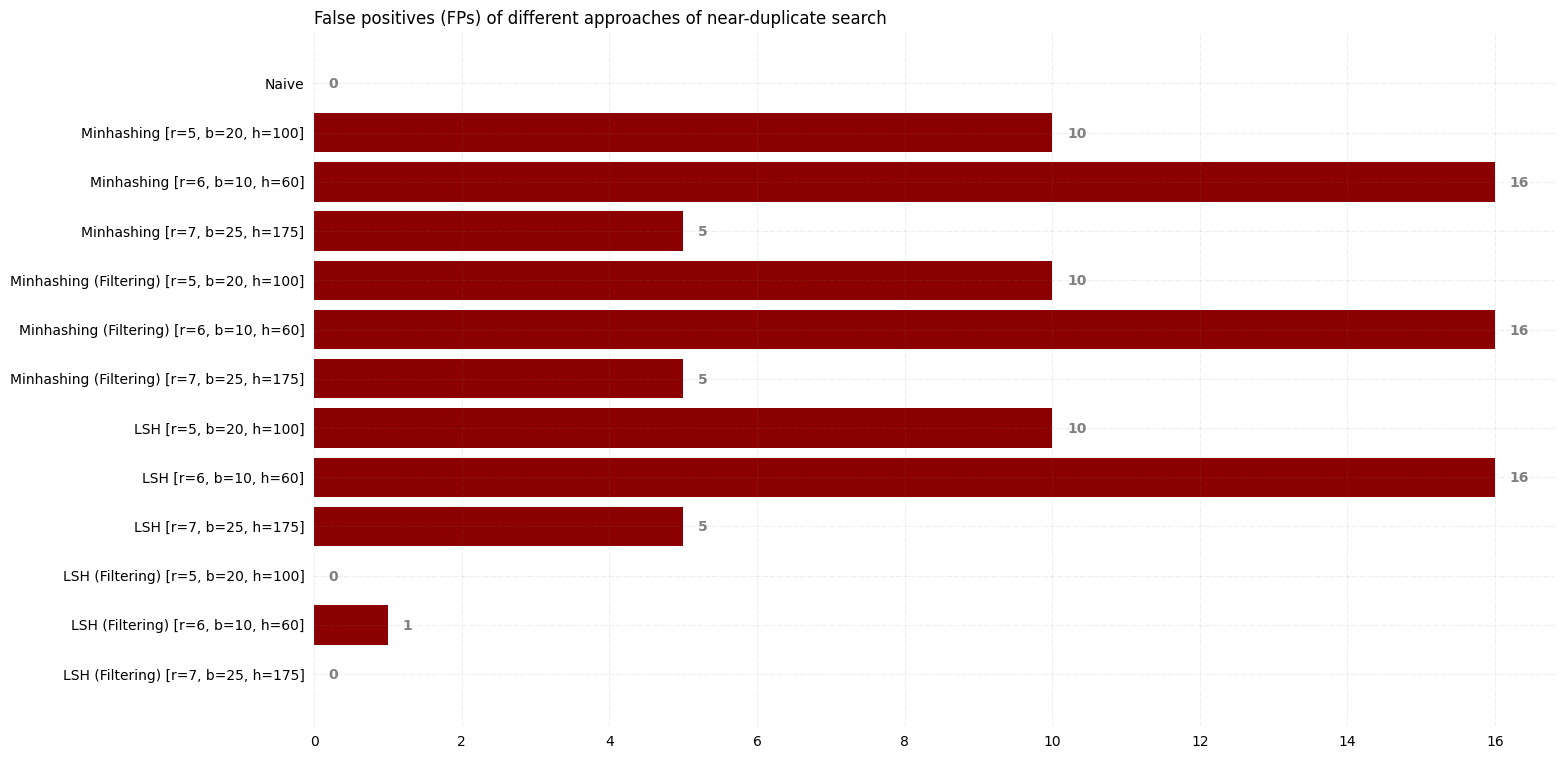

In [277]:
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(fn_df['label'].to_list(), fn_df[0].to_list(), color='darkred')

# remove axis lines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
# remove x, y ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# add x, y gridlines
ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# show top values
ax.invert_yaxis()

# add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
    
# add a title
ax.set_title('False positives (FPs) of different approaches of near-duplicate search', loc ='left')
 
plt.show()